Probability of staying in the well: 0.0


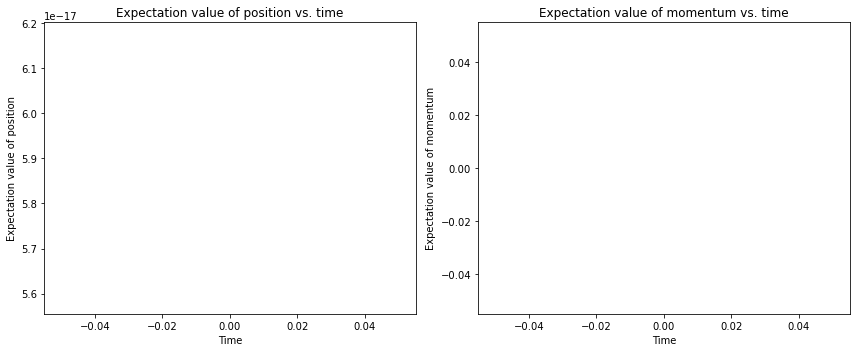

In [2]:
## Iter 2

import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Constants
m = 1.0  # Mass of the particle
hbar = 1.0  # Reduced Planck's constant
L = 10.0  # Length of the domain
N = 200  # Number of points in the discretized space
x = np.linspace(-L/2, L/2, N)  # Spatial grid
dx = x[1] - x[0]

# Define the Gaussian potential well
def gaussian_well(x, depth=-10.0, width=1.0):
    return depth * np.exp(-x**2 / (2 * width**2))

V = gaussian_well(x)
V_op = Qobj(np.diag(V))

# Define the initial state with a specific momentum
p0 = 0.0  # Initial momentum
k0 = p0 / hbar  # Corresponding wave number

# Gaussian wave packet centered at x=0
x0 = 0.0  # Initial position
sigma = 1.0  # Width of the wave packet

psi_x = (1/(sigma * np.sqrt(2 * np.pi)))**0.5 * np.exp(-(x - x0)**2 / (4 * sigma**2)) * np.exp(1j * k0 * x)
psi_x /= np.linalg.norm(psi_x)

# Convert to QuTiP Qobj
psi0 = Qobj(psi_x)

# Hamiltonian operator
T = (-hbar**2 / (2 * m)) * (np.diag(np.ones(N-1), -1) - 2 * np.diag(np.ones(N)) + np.diag(np.ones(N-1), 1)) / (dx**2)
T_op = Qobj(T)
H_op = T_op + V_op

# Define the position operator
x_op = Qobj(np.diag(x))

# Define the momentum operator using finite differences
p_op = -1j * hbar * (np.diag(np.ones(N-1), -1) - np.diag(np.ones(N-1), 1)) / (2 * dx)
p_op = Qobj(p_op)

# Function to simulate the system with a random walk effect
def simulate_random_walk(H_op, psi0, times, dt, well_depth):
    results = mesolve(H_op, psi0, times, [], [x_op, p_op])
    x_expect = results.expect[0]
    p_expect = results.expect[1]
    
    for t in range(1, len(times)):
        if 0.5 * m * (p_expect[t-1]**2) > well_depth:
            # Particle has enough energy to escape the well
            x_expect[t:] = np.nan
            p_expect[t:] = np.nan
            break
        # Add random walk effect to the momentum
        random_step = np.random.normal(0, 0.1)
        p_expect[t] += random_step
    
    return x_expect, p_expect

# Calculate total energy of the potential well
total_energy_well = np.trapz(V, x)

# Monte Carlo simulation to determine probability of staying in the well
def monte_carlo_simulation(H_op, psi0, times, dt, well_depth, num_simulations):
    stay_count = 0
    for _ in range(num_simulations):
        x_expect, p_expect = simulate_random_walk(H_op, psi0, times, dt, well_depth)
        if not np.isnan(x_expect[-1]):
            stay_count += 1
    return stay_count / num_simulations

# Parameters for simulation
times = np.linspace(0, 10, 500)
dt = times[1] - times[0]
num_simulations = 10

# Run Monte Carlo simulation
probability_staying_in_well = monte_carlo_simulation(H_op, psi0, times, dt, total_energy_well, num_simulations)

# Print results
print(f"Probability of staying in the well: {probability_staying_in_well}")

# Example of a single simulation result
x_expect, p_expect = simulate_random_walk(H_op, psi0, times, dt, total_energy_well)

# Plot the results of a single simulation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(times, x_expect)
plt.xlabel('Time')
plt.ylabel('Expectation value of position')
plt.title('Expectation value of position vs. time')

plt.subplot(1, 2, 2)
plt.plot(times, p_expect)
plt.xlabel('Time')
plt.ylabel('Expectation value of momentum')
plt.title('Expectation value of momentum vs. time')

plt.tight_layout()
plt.show()
